# Análisis de Red de Transporte Aéreo

In [1]:
#Paqueterías
using DelimitedFiles
using StatsBase
using LightGraphs
using Distributions
using GLM
using DataFrames
using Plots, LaTeXStrings
pyplot()

┌ Info: Recompiling stale cache file /Users/yuriko/.julia/compiled/v1.1/Distributions/xILW0.ji for Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1184
┌ Warning: Package Distributions does not have Test in its dependencies:
│ - If you have Distributions checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Distributions
└ Loading Test into Distributions from project dependency, future warnings for Distributions are suppressed.
┌ Info: Recompiling stale cache file /Users/yuriko/.julia/compiled/v1.1/GLM/6OREG.ji for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

### Se crea tabla de información con nodos y enlaces

In [2]:
#SE IMPORTA LA LISTA DE REDES, 521 AEROLÍNEAS, 3 ALIANZAS Y 1 GLOBAL
info_aerolineas = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/data/aerolineas_matrices/nueva_lista_aerolineas.csv", ',', String);
lista_aerolineas = info_aerolineas[:, 2]

526-element Array{String,1}:
 "Airlines"     
 "global"       
 "Star_Alliance"
 "Sky_Team"     
 "oneworld"     
 "AA"           
 "TK"           
 "DL"           
 "MU"           
 "CZ"           
 "UA"           
 "FR"           
 "BA"           
 ⋮              
 "H7"           
 "GY"           
 "EW"           
 "D6"           
 "7E"           
 "6Y"           
 "6I"           
 "5M"           
 "5G"           
 "4K"           
 "4D"           
 "4B"           

In [3]:
#NOMBRE DE LA AEROLÍNEA (ARCHIVO) ciclo for para todas las aerolíneas

tabla_info_net = ["Airline" "Nodes" "Links" "Density" "Av. Degree" "Av. Betweenness" " Global Clustering Coefficient" "Coverage" "Normalización"]

for i in 2:length(lista_aerolineas) #Desde el 2 para no tomar la primera entrada "Airlines"
    
    airline_code = lista_aerolineas[i] #Código
    aerolinea_matriz = string(airline_code, "_import_matrix.csv")
    leo_matriz = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/RESULTADOS_SCRIPT/YURIKO_TESIS/$airline_code/matriz/$aerolinea_matriz", Int64)
    
    nodos = size(leo_matriz)[1]
    enlaces = counts(leo_matriz)[2]
    
    denom = nodos * (nodos - 1)
    densidad = enlaces / denom
    
    aerolinea_in_degree = string(airline_code, "_in_degree.csv")
    #leo_in_degree = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/RESULTADOS_SCRIPT/YURIKO_TESIS/$airline_code/grados/$aerolinea_in_degree", Float64)
    promedio_degree = enlaces/nodos
    #datos_in_degree = push!(datos_in_degree, promedio_degree)
    
    grafo = DiGraph(leo_matriz)
    
    res = betweenness_centrality(grafo, endpoints=true)
    av_bet = mean(res)
    
    gcc = global_clustering_coefficient(grafo)

    aerolinea_cobertura = string(airline_code, "_layer_coverage.csv")
    leo_cobertura = readdlm("/Users/yuriko/Documents/UNAM/Tesis_Lic/RESULTADOS_SCRIPT/YURIKO_TESIS/$airline_code/cobertura2/$aerolinea_cobertura", Float64)
    #coberturas = push!(coberturas, leo_cobertura[1])

    normalizacion = leo_cobertura / nodos
    
    renglon = [airline_code nodos enlaces densidad promedio_degree av_bet gcc leo_cobertura[1] normalizacion]
    tabla_info_net = vcat(tabla_info_net, renglon)
    
end

return tabla_info_net 

526×9 Array{Any,2}:
 "Airline"            "Nodes"  …     "Coverage"   "Normalización"
 "global"         3072            543.748        0.177001        
 "Star_Alliance"   934            384.347        0.411507        
 "Sky_Team"        900            288.584        0.320648        
 "oneworld"        698            141.492        0.202711        
 "AA"              259         …   57.159        0.220691        
 "TK"              242            232.862        0.96224         
 "DL"              230             67.1714       0.29205         
 "MU"              192            180.858        0.941967        
 "CZ"              188            126.27         0.671648        
 "UA"              184         …  120.547        0.655149        
 "FR"              176            164.743        0.936038        
 "BA"              175            174.089        0.994793        
 ⋮                             ⋱                                 
 "H7"                2              2.0          1.0    

# Función para encontrar la regresión lineal

In [4]:
function regresion_lineal_norm(N::String, V::String)
    
    if N == "Global y Alianzas"
        k1 = 2
        k2 = 5
        
        elseif N == "Alianzas"
            k1 = 3
            k2 = 5
            
            elseif N == "Alianzas y Aerolíneas"
                k1 = 3
                k2 = length(lista_aerolineas)
   
                
                elseif N == "Aerolíneas"
                    k1 = 6
                    k2 = length(lista_aerolineas)
        
                    elseif N == "Todo"
                    k1 = 2
                    k2 = length(lista_aerolineas)
                
    end
    
    if V == "Nodes"
        c = 2
        t = Int64
        
        elseif V == "Links"
            c = 3
            t = Int64
            
            elseif V == "Density"
                c = 4
                t = Float64
                
                elseif V == "Av. Degree"
                    c = 5
                    t = Float64
                    
                    elseif V == "Av. Betweenness"
                        c = 6
                        t = Float64
                        
                        elseif V == "Global Clustering Coefficient"
                            c = 7
                            t = Float64
                            
                       
    end
    
    columna_x = tabla_info_net[:, c] #columna propiedad buscada (x)
    x = columna_x[k1:k2]
    x = convert(Array{t,1}, x)
    
    columna_y = tabla_info_net[:, 9] #columna cobertura normalizada (y)
    y = columna_y[k1:k2]
    y = convert(Array{Float64,1}, y)
    

    
    df_cov = hcat(x, y)
    df_cov = convert(DataFrame, df_cov)
    
    cov = lm(@formula(x2 ~ x1), df_cov)
    
    return cov
    
end

regresion_lineal_norm (generic function with 1 method)

In [5]:
function regresion_lineal_cob(N::String, V::String)
    
    if N == "Global y Alianzas"
        k1 = 2
        k2 = 5
        
        elseif N == "Alianzas"
            k1 = 3
            k2 = 5
            
            elseif N == "Alianzas y Aerolíneas"
                k1 = 3
                k2 = length(lista_aerolineas)
   
                
                elseif N == "Aerolíneas"
                    k1 = 6
                    k2 = length(lista_aerolineas)
        
                    elseif N == "Todo"
                    k1 = 2
                    k2 = length(lista_aerolineas)
                
    end
    
    if V == "Nodes"
        c = 2
        t = Int64
        
        elseif V == "Links"
            c = 3
            t = Int64
            
            elseif V == "Density"
                c = 4
                t = Float64
                
                elseif V == "Av. Degree"
                    c = 5
                    t = Float64
                    
                    elseif V == "Av. Betweenness"
                        c = 6
                        t = Float64
                        
                        elseif V == "Global Clustering Coefficient"
                            c = 7
                            t = Float64
                            
                       
    end
    
    columna_x = tabla_info_net[:, c] #columna propiedad buscada (x)
    x = columna_x[k1:k2]
    x = convert(Array{t,1}, x)
    
    columna_y = tabla_info_net[:, 8] #columna cobertura (y)
    y = columna_y[k1:k2]
    y = convert(Array{Float64,1}, y)
    
    #y_cobertura = Array{Float64}(undef, 0)
    
    df_cov = hcat(x, y)
    df_cov = convert(DataFrame, df_cov)
    
    cov = lm(@formula(x2 ~ x1), df_cov)
    
    return cov
    
end

regresion_lineal_cob (generic function with 1 method)

In [6]:
#Datos
tabla_info_net

526×9 Array{Any,2}:
 "Airline"            "Nodes"  …     "Coverage"   "Normalización"
 "global"         3072            543.748        0.177001        
 "Star_Alliance"   934            384.347        0.411507        
 "Sky_Team"        900            288.584        0.320648        
 "oneworld"        698            141.492        0.202711        
 "AA"              259         …   57.159        0.220691        
 "TK"              242            232.862        0.96224         
 "DL"              230             67.1714       0.29205         
 "MU"              192            180.858        0.941967        
 "CZ"              188            126.27         0.671648        
 "UA"              184         …  120.547        0.655149        
 "FR"              176            164.743        0.936038        
 "BA"              175            174.089        0.994793        
 ⋮                             ⋱                                 
 "H7"                2              2.0          1.0    

In [7]:
#Betweenness
betweenness = tabla_info_net[:,6]

526-element Array{Any,1}:
  "Av. Betweenness"   
 0.0016388726164783274
 0.004474792240078254 
 0.004819743898675947 
 0.006119872899938487 
 0.01346844342953292  
 0.013208566235725793 
 0.014520233562832463 
 0.019180989942132822 
 0.018714589473400888 
 0.019758647743323438 
 0.018216151664427527 
 0.02178346004536956  
 ⋮                    
 2.0                  
 2.0                  
 2.0                  
 2.0                  
 2.0                  
 2.0                  
 2.0                  
 2.0                  
 2.0                  
 2.0                  
 2.0                  
 2.0                  

In [8]:
#Cobertura
coverage = tabla_info_net[:,8]

526-element Array{Any,1}:
    "Coverage"     
 543.7477376302082 
 384.3474197002141 
 288.5836444444444 
 141.49216332378222
  57.15899613899614
 232.8619834710744 
  67.1714347826087 
 180.85765625      
 126.26984042553191
 120.54739130434781
 164.74267045454545
 174.08885714285708
   ⋮               
   2.0             
   2.0             
   1.5             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             

In [9]:
#Variables Densidad y Cobertura

betweenness_x = betweenness[2:end]

cobertura_y = coverage[2:end]




525-element Array{Any,1}:
 543.7477376302082 
 384.3474197002141 
 288.5836444444444 
 141.49216332378222
  57.15899613899614
 232.8619834710744 
  67.1714347826087 
 180.85765625      
 126.26984042553191
 120.54739130434781
 164.74267045454545
 174.08885714285708
 113.85226744186045
   ⋮               
   2.0             
   2.0             
   1.5             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             

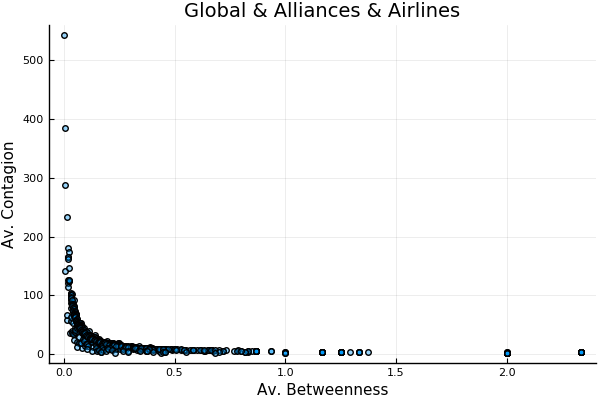

In [11]:
# Grafico betweenness vs cobertura

plot_betweenness_cobertura = scatter(betweenness_x, cobertura_y,
                                    title = "Global & Alliances & Airlines",
                                    xlabel = "Av. Betweenness",
                                    ylabel = "Av. Contagion",
                                    legend = false,
                                    #size = (500,500),
                                    #aspect_ratio= 1,
                                    alpha = 0.4)

In [12]:
#División

betweenness_x_g = betweenness_x[1]
betweenness_x_al = betweenness_x[2:4]
betweenness_x_aer = betweenness_x[5:end]

cobertura_y_g = cobertura_y[1]
cobertura_y_al = cobertura_y[2:4]
cobertura_y_aer = cobertura_y[5:end]

521-element Array{Any,1}:
  57.15899613899614
 232.8619834710744 
  67.1714347826087 
 180.85765625      
 126.26984042553191
 120.54739130434781
 164.74267045454545
 174.08885714285708
 113.85226744186045
 164.4432352941176 
 162.58869047619046
 147.2706081081081 
 124.3578125       
   ⋮               
   2.0             
   2.0             
   1.5             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             
   2.0             

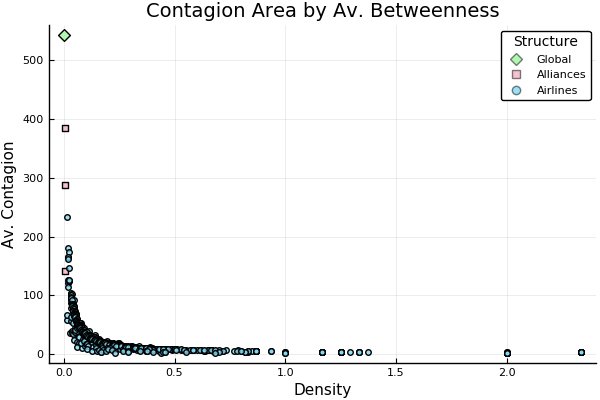

In [29]:
# Grafico densidad vs cobertura dividido

plot_betweenness_cobertura = scatter([betweenness_x_g], [cobertura_y_g],
                                    title = "Contagion Area by Av. Betweenness",
                                    xlabel = "Density",
                                    ylabel = "Av. Contagion",
                                    legend = true,
                                    legendtitle = "Structure",
                                    label = "Global",
                                    #size = (500,500),
                                    #aspect_ratio= 1,
                                    markershape = :diamond,
                                    markersize = 6,
                                    #markeralpha = 0.6,
                                    markercolor = "#A9F5A9",
                                    markerstrokealpha = 0.5,
                                    alpha = 0.9)
scatter!(betweenness_x_al, cobertura_y_al,
            legend = true,
            label = "Alliances",
            markershape = :square,
            markersize = 5,
            markeralpha = 0.7,#,
            markerstrokealpha = 0.5,
            markercolor = "#F5A9BC")
scatter!(betweenness_x_aer, cobertura_y_aer,
            legend = true,
            label = "Airlines",
            markershape = :circle,
            markersize = 4,
            markercolor = "#81DAF5",
            markerstrokealpha = 0.5,
            markeralpha = 0.8)

In [30]:
savefig(plot_betweenness_cobertura, "/Users/yuriko/Desktop/plot_betweenness_cobertura.pdf")

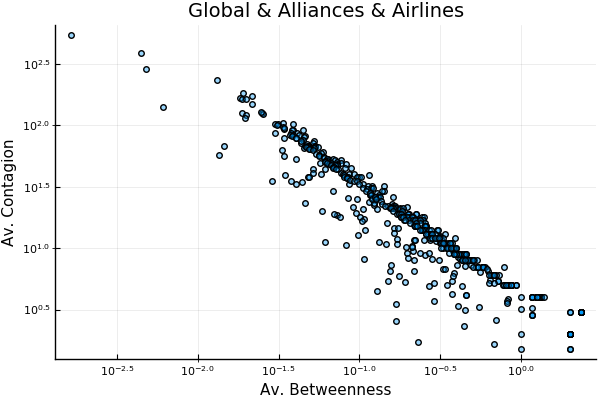

In [15]:
# Grafico en escala log-log
plot_betweenness_cobertura_log = scatter(betweenness_x, cobertura_y,
                                        xscale =(:log10),
                                        yscale =(:log10),
                                        title = "Global & Alliances & Airlines",
                                        xlabel = "Av. Betweenness",
                                        ylabel = "Av. Contagion",
                                        legend = false,
                                        #size = (500,500),
                                        #aspect_ratio= 1,
                                        alpha = 0.4)

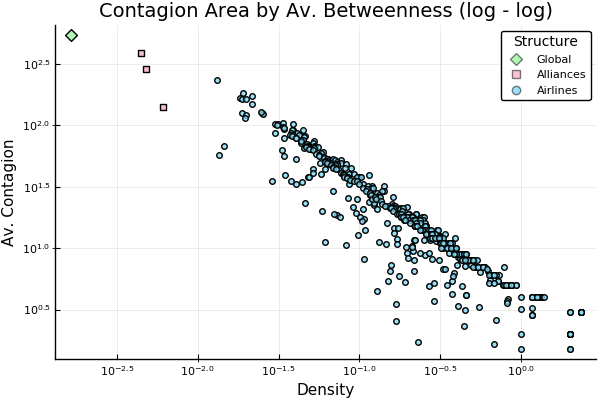

In [28]:
plot_betweenness_cobertura_log = scatter([betweenness_x_g], [cobertura_y_g],
                                    title = "Contagion Area by Av. Betweenness (log - log)",
                                    xlabel = "Density",
                                    ylabel = "Av. Contagion",
                                    xscale =(:log10),
                                    yscale =(:log10),
                                    legend = true,
                                    legendtitle = "Structure",
                                    label = "Global",
                                    #size = (500,500),
                                    #aspect_ratio= 1,
                                    markershape = :diamond,
                                    markersize = 6,
                                    #markeralpha = 0.6,
                                    markercolor = "#A9F5A9",
                                    markerstrokealpha = 0.5,
                                    alpha = 0.9)
scatter!(betweenness_x_al, cobertura_y_al,
            legend = true,
            label = "Alliances",
            markershape = :square,
            markersize = 5,
            markeralpha = 0.7,#,
            markerstrokealpha = 0.5,
            markercolor = "#F5A9BC")
scatter!(betweenness_x_aer, cobertura_y_aer,
            legend = true,
            label = "Airlines",
            markershape = :circle,
            markersize = 4,
            markercolor = "#81DAF5",
            markerstrokealpha = 0.5,
            markeralpha = 0.8)

In [17]:
# Hago una tabla betweenness, cobertura

df_betweenness_cobertura = hcat(betweenness_x, cobertura_y)
df_betweenness_cobertura = convert(DataFrame, df_betweenness_cobertura)

,x1,x2
,Float64,Float64
1,0.00163887,543.748
2,0.00447479,384.347
3,0.00481974,288.584
4,0.00611987,141.492
5,0.0134684,57.159
6,0.0132086,232.862
7,0.0145202,67.1714
8,0.019181,180.858
9,0.0187146,126.27


In [18]:
#Obtengo log_betweenness
log_betweenness = log.(df_betweenness_cobertura.x1)

525-element Array{Float64,1}:
 -6.413746702510298 
 -5.409295355131231 
 -5.335034485386021 
 -5.096213950657467 
 -4.30740585354957  
 -4.326889702619558 
 -4.232212184120336 
 -3.9538355976088764
 -3.978451873564926 
 -3.924164023046467 
 -4.005446624364519 
 -3.826604310671017 
 -3.9301033305288935
  ⋮                 
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453
  0.6931471805599453

In [19]:
#Obtengo log_cobertura
log_cobertura = log.(df_betweenness_cobertura.x2)

525-element Array{Float64,1}:
 6.298485421714162 
 5.951546882360908 
 5.664984972677177 
 4.9522443326788075
 4.04583679060857  
 5.450445932442019 
 4.207248079518242 
 5.197710292309866 
 4.8384212076938065
 4.79204296444569  
 5.104384683497936 
 5.159565842100139 
 4.734901708357632 
 ⋮                 
 0.6931471805599453
 0.6931471805599453
 0.4054651081081644
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453
 0.6931471805599453

In [20]:
#Lo convierto en un data frame

df_betweenness_cobertura_log = hcat(log_betweenness, log_cobertura)
df_betweenness_cobertura_log = convert(DataFrame, df_betweenness_cobertura_log)

,x1,x2
,Float64,Float64
1,-6.41375,6.29849
2,-5.4093,5.95155
3,-5.33503,5.66498
4,-5.09621,4.95224
5,-4.30741,4.04584
6,-4.32689,5.45045
7,-4.23221,4.20725
8,-3.95384,5.19771
9,-3.97845,4.83842


In [21]:
#Ajustamos una recta x2 = log(cobertura) y x1=log(betweenness)
ajuste_log_betweenness_cobertura = lm(@formula(x2 ~ x1), df_betweenness_cobertura_log)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: x2 ~ 1 + x1

Coefficients:
              Estimate Std.Error  t value Pr(>|t|)
(Intercept)    1.38965 0.0243529  57.0629   <1e-99
x1           -0.846983 0.0125207 -67.6469   <1e-99


In [22]:
coeficientes_bc = round.(coef(ajuste_log_betweenness_cobertura), digits=5)

2-element Array{Float64,1}:
  1.38965
 -0.84698

In [23]:
r_2 = round.(r2(ajuste_log_betweenness_cobertura), digits=5)

0.89743

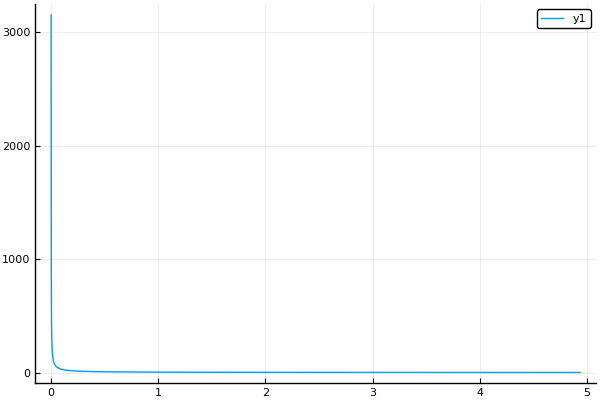

In [24]:
my_equation(x) = exp(coeficientes_bc[2]*log(x) + coeficientes_bc[1])
plot(my_equation)

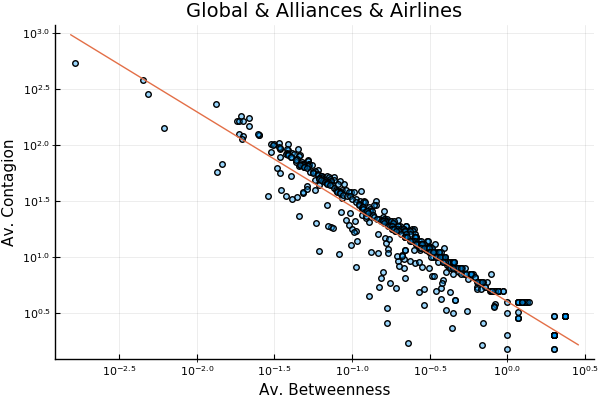

In [25]:
# Grafico en escala log-log
plot_betweenness_cobertura_log = scatter(betweenness_x, cobertura_y,
                                        xscale =(:log10),
                                        yscale =(:log10),
                                        title = "Global & Alliances & Airlines",
                                        xlabel = "Av. Betweenness",
                                        ylabel = "Av. Contagion",
                                        legend = false,
                                        #size = (500,500),
                                        #aspect_ratio= 1,
                                        alpha = 0.4)
plot!(my_equation)

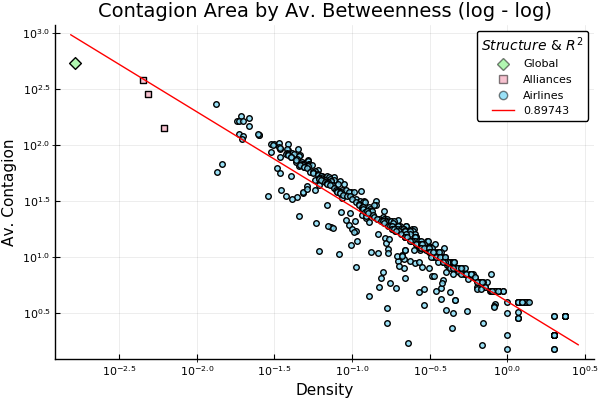

In [27]:
# Grafico en escala log-log con ajuste

plot_betweenness_cobertura_log = scatter([betweenness_x_g], [cobertura_y_g],
                                    title = "Contagion Area by Av. Betweenness (log - log)",
                                    xlabel = "Density",
                                    ylabel = "Av. Contagion",
                                    xscale =(:log10),
                                    yscale =(:log10),
                                    legend = true,
                                    legendtitle = L"Structure\ &\ R^2",
                                    label = "Global",
                                    #size = (500,500),
                                    #aspect_ratio= 1,
                                    markershape = :diamond,
                                    markersize = 6,
                                    #markeralpha = 0.6,
                                    markercolor = "#A9F5A9",
                                    markerstrokealpha = 0.5,
                                    alpha = 0.9)
scatter!(betweenness_x_al, cobertura_y_al,
            legend = true,
            label = "Alliances",
            markershape = :square,
            markersize = 5,
            markeralpha = 0.7,#,
            markerstrokealpha = 0.5,
            markercolor = "#F5A9BC")
scatter!(betweenness_x_aer, cobertura_y_aer,
            legend = true,
            label = "Airlines",
            markershape = :circle,
            markersize = 4,
            markercolor = "#81DAF5",
            markerstrokealpha = 0.5,
            markeralpha = 0.8)
plot!(my_equation,
        legend = true,
        label = "$r_2",
        linecolor = :red)

In [31]:
savefig(plot_betweenness_cobertura_log, "/Users/yuriko/Desktop/plot_betweenness_cobertura_log.pdf")

### Encontramos la regresión

In [6]:
reg_ab_aa = regresion_lineal_norm("Alianzas y Aerolíneas", "Av. Betweenness")

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: x2 ~ 1 + x1

Coefficients:
              Estimate Std.Error t value Pr(>|t|)
(Intercept)   0.860144  0.011049 77.8478   <1e-99
x1           0.0676561 0.0147006 4.60227    <1e-5


In [7]:
coef_r = round.(coef(reg_ab_aa), digits=6)

2-element Array{Float64,1}:
 0.860144
 0.067656

In [8]:
r_2 = round.(r2(reg_ab_aa), digits=5)

0.03899

### Gráfica de cobertura (Betweenness vs. Cobertura. Alianzas & Aerolíneas)

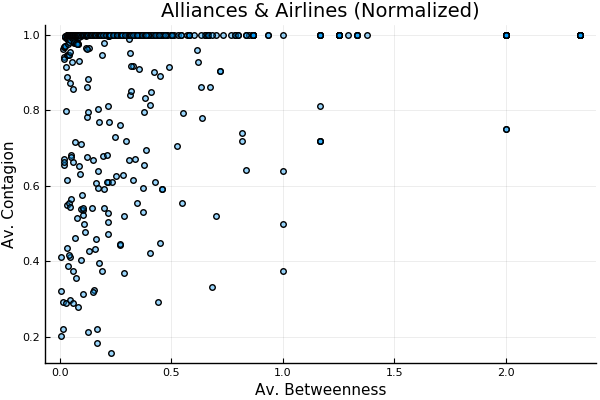

In [9]:

w = tabla_info_net[:, 6] #Nodos
c = tabla_info_net[:, 9] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, w[i])
    y = push!(y, c[i])
end


equation(x) = 0.0676561*x + 0.860144 #

betweenness_normalizada = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines (Normalized)",
    xlabel = "Av. Betweenness",
    ylabel = "Av. Contagion",
    legend = false,
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, 0:0.1:2.5, 
#    legend = true,
#    label = "$r_2")



In [10]:
savefig(betweenness_normalizada, "/Users/yuriko/Desktop/betweenness_normalizada.pdf")

### Encontramos la regresión

In [11]:
reg_ab_aa = regresion_lineal_cob("Alianzas y Aerolíneas", "Av. Betweenness")

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: x2 ~ 1 + x1

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)   38.4477   1.86857   20.576   <1e-68
x1           -25.8322   2.48611 -10.3906   <1e-22


In [12]:
coef_r = round.(coef(reg_ab_aa), digits=6)

2-element Array{Float64,1}:
  38.447731
 -25.832153

In [13]:
r_2 = round.(r2(reg_ab_aa), digits=5)

0.17138

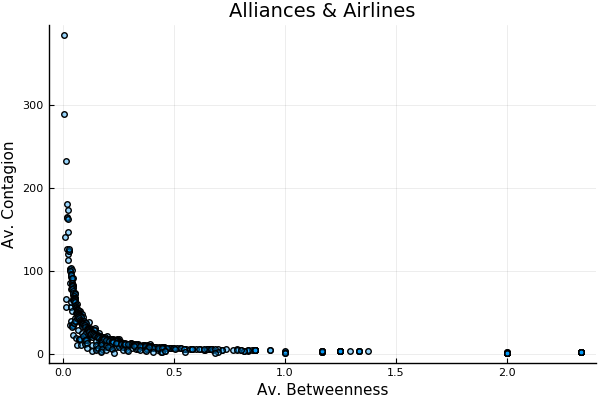

In [14]:

w = tabla_info_net[:, 6] #Nodos
c = tabla_info_net[:, 8] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, w[i])
    y = push!(y, c[i])
end


#equation(x) = -25.908*x + 38.6067 #

betweenness_no_norm = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines",
    xlabel = "Av. Betweenness",
    ylabel = "Av. Contagion",
    legend = false,
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, 0:0.1:2.5, 
 #   legend = true)



In [15]:
savefig(betweenness_no_norm, "/Users/yuriko/Desktop/betweenness_no_norm.pdf")

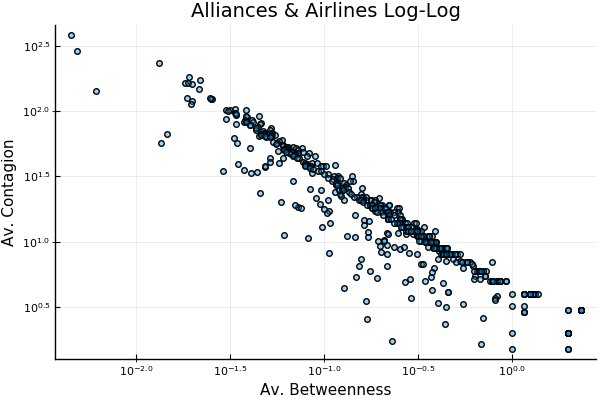

In [16]:

#w = tabla_info_net[:, 6] #Betweenness
#c = tabla_info_net[:, 8] #Coberturas
#
#x = Array{Float64}(undef, 0)
#y = Array{Float64}(undef, 0)
#for i in 3:length(lista_aerolineas)
#    x = push!(x, w[i])
#    y = push!(y, c[i])#
#end


#equation(x) = -0.850142*x + 1.38602 #

betweenness_log_log = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines Log-Log",
    xlabel = "Av. Betweenness",
    xscale=(:log10),
    ylabel = "Av. Contagion",
    yscale=(:log10),
    legend = false,
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, -6:0.1:1, 
#    legend = true,
#    label = "$r_2")
#



In [17]:
savefig(betweenness_log_log, "/Users/yuriko/Desktop/betweenness_log_log.pdf")

In [18]:
#log recta

    df_cov = hcat(x, y)
    df_cov = convert(DataFrame, df_cov)
    
    cov = lm(@formula(x2 ~ x1), df_cov)
    

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: x2 ~ 1 + x1

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)   38.4477   1.86857   20.576   <1e-68
x1           -25.8322   2.48611 -10.3906   <1e-22


In [19]:
coef_r = round.(coef(cov), digits=6)

2-element Array{Float64,1}:
  38.447731
 -25.832153

In [20]:
r_2 = round.(r2(cov), digits=5)

0.17138

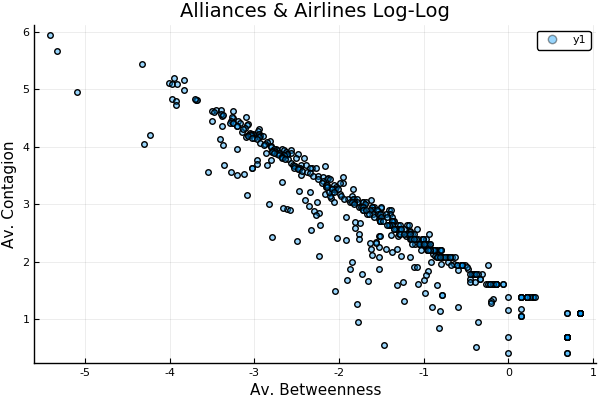

In [21]:

w = tabla_info_net[:, 6] #Betweenness
c = tabla_info_net[:, 8] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, log(w[i]))
    y = push!(y, log(c[i]))
end


equation(x) = -0.850142*x + 1.38602 #

scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines Log-Log",
    xlabel = "Av. Betweenness",
    #xscale=(:log10),
    ylabel = "Av. Contagion",
    #yscale=(:log10),
    legend = true,
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
#plot!(equation, -6:0.1:1, 
#    legend = true,
#    label = "$r_2")
#


In [22]:
#log recta

    df_cov = hcat(x, y)
    df_cov = convert(DataFrame, df_cov)
    
    cov = lm(@formula(x2 ~ x1), df_cov)
    

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: x2 ~ 1 + x1

Coefficients:
              Estimate Std.Error  t value Pr(>|t|)
(Intercept)    1.38602 0.0244525  56.6819   <1e-99
x1           -0.850142  0.012692 -66.9823   <1e-99


In [23]:
coef_r = round.(coef(cov), digits=6)

2-element Array{Float64,1}:
  1.386018
 -0.850142

In [24]:
r_2 = round.(r2(cov), digits=5)

0.89578

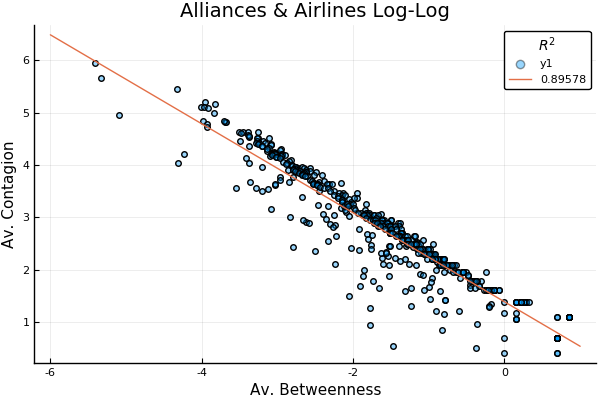

In [25]:

w = tabla_info_net[:, 6] #Betweenness
c = tabla_info_net[:, 8] #Coberturas

x = Array{Float64}(undef, 0)
y = Array{Float64}(undef, 0)
for i in 3:length(lista_aerolineas)
    x = push!(x, log(w[i]))
    y = push!(y, log(c[i]))
end


equation(x) = -0.850142*x + 1.38602 #

betweenness_log_recta = scatter(x, y,
    #color = "#0f87bf",
    title = "Alliances & Airlines Log-Log",
    xlabel = "Av. Betweenness",
    #xscale=(:log10),
    ylabel = "Av. Contagion",
    #yscale=(:log10),
    legend = true,
    #size = (500,500),
    #aspect_ratio= 1,
    alpha = 0.4)
plot!(equation, -6:0.1:1, 
    legend = true,
    legendtitle = L"R^2",
    label = "$r_2")

In [26]:
savefig(betweenness_log_recta, "/Users/yuriko/Desktop/betweenness_log_recta.pdf")